In [16]:
! source ~/yolo_ws/install/setup.bash

In [69]:
import pandas as pd
from rosbags.rosbag2 import Reader
from rosbags.typesys import Stores, get_typestore, get_typestore, get_types_from_msg, register_types
from rosbags.typesys.types import std_msgs__msg__Float64, geometry_msgs__msg__PoseStamped, geometry_msgs__msg__Twist, geometry_msgs__msg__PointStamped
import re
from vision_msgs.msg import Detection3DArray, Detection3D, ObjectHypothesisWithPose, BoundingBox3D
from pathlib import Path

# Custom message definitions
vision_msgs_msg_Detection3DArray = """
std_msgs/Header header
vision_msgs/Detection3D[] detections
"""

vision_msgs_msg_Detection3D = """
std_msgs/Header header
vision_msgs/ObjectHypothesisWithPose[] results
vision_msgs/BoundingBox3D bbox
string id
"""

vision_msgs_msg_ObjectHypothesisWithPose = """
ObjectHypothesis hypothesis
geometry_msgs/PoseWithCovariance pose
"""

vision_msgs_msg_ObjectHypothesis = """
string class_id
float64 score
"""


vision_msgs_msg_BoundingBox3D = """
geometry_msgs/Pose center
geometry_msgs/Vector3 size
"""

# Initialize type store
typestore = get_typestore(Stores.ROS2_HUMBLE)

# Register the message types
typestore.register(get_types_from_msg(vision_msgs_msg_BoundingBox3D, 'vision_msgs/msg/BoundingBox3D'))
typestore.register(get_types_from_msg(vision_msgs_msg_ObjectHypothesis, 'vision_msgs/msg/ObjectHypothesis'))
typestore.register(get_types_from_msg(vision_msgs_msg_ObjectHypothesisWithPose, 'vision_msgs/msg/ObjectHypothesisWithPose'))
typestore.register(get_types_from_msg(vision_msgs_msg_Detection3D, 'vision_msgs/msg/Detection3D'))
typestore.register(get_types_from_msg(vision_msgs_msg_Detection3DArray, 'vision_msgs/msg/Detection3DArray'))



# Define a function to process each message type
def process_message(msg, msgtype, connection):
    # print(f'msgtype: {msgtype}')
    if msgtype == 'std_msgs/msg/Float64':
        if 'mean' in connection.topic:
            return {'average_distance_mean': msg.data}
        if 'std' in connection.topic:
            return {'average_distance_std': msg.data}
        if 'min' in connection.topic:
            return {'average_distance_min': msg.data}
        if 'max' in connection.topic:
            return {'average_distance_max': msg.data}
    elif msgtype == 'geometry_msgs/msg/PoseStamped':
        return {
            'position_x': msg.pose.position.x,
            'position_y': msg.pose.position.y,
            'position_z': msg.pose.position.z,
            'orientation_x': msg.pose.orientation.x,
            'orientation_y': msg.pose.orientation.y,
            'orientation_z': msg.pose.orientation.z,
            'orientation_w': msg.pose.orientation.w
        }
    elif msgtype == 'geometry_msgs/msg/Twist':
        return {
            'linear_x': msg.twist.linear.x,
            'linear_y': msg.twist.linear.y,
            'linear_z': msg.twist.linear.z,
            'angular_x': msg.twist.angular.x,
            'angular_y': msg.twist.angular.y,
            'angular_z': msg.twist.angular.z
        }
    # Add more processing logic for other message types if needed
    elif msgtype == 'geometry_msgs/msg/PointStamped':
        return {
            'migration_x': msg.point.x,
            'migration_y': msg.point.y,
            'migration_z': msg.point.z
        }
    elif msgtype == 'vision_msgs/msg/Detection3DArray':
        if 'filtered' in connection.topic:
            # print(f'connection.topic: {connection.topic}')
            # print(f"msg.detections: {msg.detections}")
            # loop through all the detections return a list of dictionaries
            detections = []
            for detection in msg.detections:
                # print(f"detection: {detection.bbox.center.position.x}")
                detections.append({
                    'filtered_position_x': detection.bbox.center.position.x,
                    'filtered_position_y': detection.bbox.center.position.y,
                    'filtered_position_z': detection.bbox.center.position.z,
                })
            print(f"detections: {detections}")
            return {'detections': detections}

# Function to extract drone number from topic or return 'swarm' if found
def get_drone_number(topic):
    if 'swarm' in topic:
        return 'swarm'
    match = re.search(r'drone(\d+)', topic)
    if match:
        return int(match.group(1))
    return None

# Initialize a dictionary to store data
data_dict = {
    'timestamp': [],
    'topic': [],
    'drone_number': [],
    'data': []
}

# Open the ROS bag for reading
with Reader('/home/azureuser/project_gazebo/rosbag/rosbags/rosbag2_2024_05_24-07_42_04') as reader:
    # Iterate over messages
    for connection, timestamp, rawdata in reader.messages():
            if 'as2_msgs' in connection.msgtype:
                continue
            # print(f'connection.msgtype: {connection.msgtype}')
            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)
            # print(f'connection.msgtype: {connection.msgtype}')
            processed_data = process_message(msg, connection.msgtype)
            
            if processed_data is not None:
                data_dict['timestamp'].append(timestamp)
                data_dict['topic'].append(connection.topic)
                data_dict['drone_number'].append(get_drone_number(connection.topic))
                data_dict['data'].append(processed_data)
        # except Exception as e:
        #     if 'as2_msgs' in connection.msgtype:
        #         continue
        #     else:
        #         print(f'Error processing message: {e}')
        #         continue

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(data_dict)

# Normalize the data column which contains dictionaries
df = df.join(pd.json_normalize(df.pop('data')))

/tmp/ipykernel_18304/2409876825.py:41: DeprecationWarning: Global type registration has been replaced with explicit typestores.

Perform all type registration and subsequent serialization and
deserialization on typestore instances:

from rosbags.typesys import Stores, get_typestore

typestore = get_typestore(Stores.ROS2_FOXY)
typestore.register(types)
  register_types(typestore, get_types_from_msg(vision_msgs_msg_BoundingBox3D, 'vision_msgs/msg/BoundingBox3D'))


AttributeError: 'dict' object has no attribute 'register'

detections: [{'filtered_position_x': 0.9433807435482511, 'filtered_position_y': 0.0013849872743269167, 'filtered_position_z': 0.0}, {'filtered_position_x': 0.8153565000017189, 'filtered_position_y': 2.47357832378488, 'filtered_position_z': 0.0}]
detections: [{'filtered_position_x': -0.8996386049326942, 'filtered_position_y': -0.0022639135091380453, 'filtered_position_z': 0.0}, {'filtered_position_x': -0.7490206387191156, 'filtered_position_y': 2.278980962227045, 'filtered_position_z': 0.0}]
detections: []
detections: [{'filtered_position_x': 0.9433880454830805, 'filtered_position_y': 0.0013855991330249296, 'filtered_position_z': 0.0}, {'filtered_position_x': 0.8154116500661531, 'filtered_position_y': 2.4737207219020525, 'filtered_position_z': 0.0}]
detections: [{'filtered_position_x': -0.899638465875059, 'filtered_position_y': -0.0022604079250708115, 'filtered_position_z': 0.0}, {'filtered_position_x': -0.7490309242032719, 'filtered_position_y': 2.2790113946696726, 'filtered_position_z

In [68]:
df

,timestamp,topic,drone_number,detections,position_x,position_y,position_z,orientation_x,orientation_y,orientation_z,orientation_w,average_distance_mean,average_distance_std,average_distance_min,average_distance_max
0,1716536704733175421,/metrics/drone0/filtered_detections,0,"[{'filtered_position_x': 0.9433807435482511, '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1716536704733369293,/metrics/drone0/pose,0,NaN,-5.000000e-01,-0.57735,0.001697,2.685531e-18,-4.629256e-18,1.718887e-17,1.0,NaN,NaN,NaN,NaN
2,1716536704734445621,/metrics/drone1/filtered_detections,1,"[{'filtered_position_x': -0.8996386049326942, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1716536704735063123,/metrics/drone1/pose,1,NaN,5.000000e-01,-0.57735,0.001697,1.114476e-18,-6.051735e-18,1.796097e-17,1.0,NaN,NaN,NaN,NaN
4,1716536704735418145,/metrics/drone2/pose,2,NaN,-3.466507e-18,1.15470,0.001697,-1.099070e-16,4.975934e-17,1.208772e-17,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4675,1716537171722193422,/metrics/drone2/filtered_detections,2,"[{'filtered_position_x': -2.5872913135444446, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4676,1716537171724514651,/metrics/swarm/agent_distances_mean,swarm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.36948,NaN,NaN,NaN
4677,1716537171725295727,/metrics/swarm/agent_distances_std,swarm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.568814,NaN,NaN
4678,1716537171725643595,/metrics/swarm/agent_distances_min,swarm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.607249,NaN


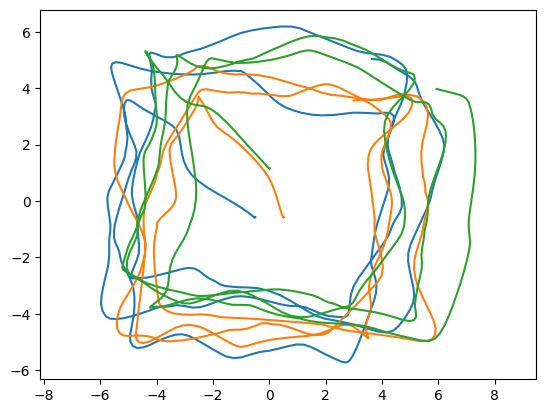

In [76]:
# plot the x and y position of each drone
import matplotlib.pyplot as plt

for drone_number in df['drone_number'].unique():
    if drone_number == 'swarm':
        continue
    drone_data = df[df['drone_number'] == drone_number]
    plt.plot(drone_data['position_x'], drone_data['position_y'], label=f'Drone {drone_number}')
    # make axis equal
    plt.axis('equal')
    

In [37]:
# convert timestamp to seconds and add as new column
# Ensure 'timestamp' column is in datetime format
min_timestamp = df['timestamp'].min()
df['time_seconds'] = (df['timestamp'] - min_timestamp) / 1e9

df

,timestamp,topic,drone_number,position_x,position_y,position_z,orientation_x,orientation_y,orientation_z,orientation_w,average_distance_mean,average_distance_std,average_distance_min,average_distance_max,time_seconds
0,1716536704733369293,/metrics/drone0/pose,0,-5.000000e-01,-0.577350,0.001697,2.685531e-18,-4.629256e-18,1.718887e-17,1.000000,NaN,NaN,NaN,NaN,0.000000
1,1716536704735063123,/metrics/drone1/pose,1,5.000000e-01,-0.577350,0.001697,1.114476e-18,-6.051735e-18,1.796097e-17,1.000000,NaN,NaN,NaN,NaN,0.001694
2,1716536704735418145,/metrics/drone2/pose,2,-3.466507e-18,1.154700,0.001697,-1.099070e-16,4.975934e-17,1.208772e-17,1.000000,NaN,NaN,NaN,NaN,0.002049
3,1716536704737641603,/metrics/swarm/agent_distances_mean,swarm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.535183,NaN,NaN,NaN,0.004272
4,1716536704738987073,/metrics/swarm/agent_distances_std,swarm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.378432,NaN,NaN,0.005618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3271,1716537171722184966,/metrics/drone2/pose,2,5.932747e+00,3.973573,9.998886,-4.677721e-03,-2.659549e-02,-1.021233e-01,0.994405,NaN,NaN,NaN,NaN,466.988816
3272,1716537171724514651,/metrics/swarm/agent_distances_mean,swarm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.369480,NaN,NaN,NaN,466.991145
3273,1716537171725295727,/metrics/swarm/agent_distances_std,swarm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.568814,NaN,NaN,466.991926
3274,1716537171725643595,/metrics/swarm/agent_distances_min,swarm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.607249,NaN,466.992274


In [72]:
# separate the data for each average_distance topic
df_mean = df[['time_seconds', 'average_distance_mean']].dropna()
df_min = df[['time_seconds', 'average_distance_min']].dropna()
df_max = df[['time_seconds', 'average_distance_max']].dropna()
df_std = df[['time_seconds', 'average_distance_std']].dropna()


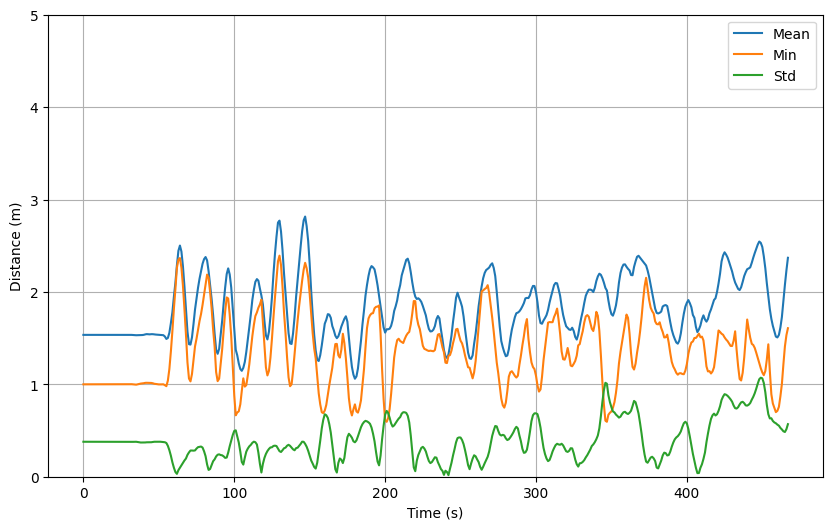

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(df_mean['time_seconds'], df_mean['average_distance_mean'], label='Mean')
plt.plot(df_min['time_seconds'], df_min['average_distance_min'], label='Min')
# plt.plot(df_max['time_seconds'], df_max['average_distance_max'], label='Max')
plt.plot(df_std['time_seconds'], df_std['average_distance_std'], label='Std')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
# set y axis limits to 0 and 5
plt.ylim(0, 5)
# show grid
plt.grid()
plt.legend()
plt.show()